<a href="https://colab.research.google.com/github/NahuelCostaCortez/rapidae/blob/main/examples/RVE_RUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RVE for Remaining Useful Life Estimation (RUL)

In [ ]:
# Install the library

!pip install rapidae

In [10]:
import numpy as np
from rapidae.data import load_CMAPSS, CMAPSS_preprocessor
from rapidae.models import RVE
from rapidae.pipelines import PreprocessPipeline, TrainingPipeline
from rapidae.evaluate import evaluate, cmapps_score, plot_latent_space
from sklearn.metrics import mean_squared_error

### Data

The data used is the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS) dataset, a popular benchmark in the field of predictive maintenance. The C-MAPSS dataset comprises four subsets with run-to-failure trajectories of aircraft engines and the task is to predict the RUL of an engine, which is a regression task. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type.

Fix some parameters:
 - The selected subset
 - The specific sensors
 - The length of the window
 - The smoothing instensity
 - The max RUL

For more information you can check the paper: https://www.sciencedirect.com/science/article/pii/S2665963822000537

In [4]:
subset = 'FD004'
# sensors to work with: T30, T50, P30, PS30, phi
sensors = ['s_3', 's_4', 's_7', 's_10', 's_11', 's_12']
# windows length
sequence_length = 30
# smoothing intensity
alpha = 0.1
# max RUL
threshold = 125

The CMAPSS_preprocessor encapsulates a set of operations in order to prepare properly the data, like generating the RUL values, remove unused sensors, scaling, smoothing, etc.

In [6]:
data = load_CMAPSS(subset)

preprocess_pipeline = PreprocessPipeline(name='CMAPPS_preprocessing',
                                         preprocessor=CMAPSS_preprocessor)

data = preprocess_pipeline(train=data["x_train"],
                           test=data["x_test"],
                           y_test=data["y_test"],
                           sensors=sensors,
                           sequence_length=sequence_length,
                           alpha=alpha,
                           threshold=threshold)

### Model

Fix hyperparameters for the model.

In [7]:
timesteps = data["x_train"].shape[1]
input_dim = data["x_train"].shape[2]
intermediate_dim = 300
batch_size = 128
latent_dim = 2

Create the model. Since we are working with a predefined model the original layers configuration are set by default.

In [11]:
model = RVE(input_dim=(timesteps, input_dim),
            latent_dim=2,
            downstream_task='regression')

### Training

Create and lauch the pipeline to train the model, in this example we have evaluation data so it can be fed as a dict to the pipeline.

In [12]:
epochs = 10000 # doesn't matter, we use early stopping
optimizer = 'adam'
pipeline = TrainingPipeline(name='RVE_RUL',
                            model=model,
                            num_epochs=epochs,
                            batch_size=batch_size,
                            optimizer='adam',
                            learning_rate=0.01
                            )

trained_model = pipeline(x=data["x_train"], y=data["y_train"], x_eval=data["x_val"], y_eval=data["y_val"])

Epoch 1/10000

Epoch 1: val_loss improved from inf to 589.80212, saving model to ./output_dir/RVE_RUL_2024-01-28_19-18-53/model.weights.h5
341/341 - 197s - 577ms/step - kl_loss: 39.6225 - loss: 1046.2275 - reg_loss: 1006.6055 - val_kl_loss: 21.7472 - val_loss: 589.8021 - val_reg_loss: 568.0548
Epoch 2/10000

Epoch 2: val_loss did not improve from 589.80212
341/341 - 203s - 596ms/step - kl_loss: 20.7936 - loss: 454.3112 - reg_loss: 433.5172 - val_kl_loss: 26.9709 - val_loss: 736.0234 - val_reg_loss: 709.0524
Epoch 3/10000

Epoch 3: val_loss improved from 589.80212 to 398.54547, saving model to ./output_dir/RVE_RUL_2024-01-28_19-18-53/model.weights.h5
341/341 - 187s - 550ms/step - kl_loss: 14.7388 - loss: 319.1683 - reg_loss: 304.4296 - val_kl_loss: 13.3821 - val_loss: 398.5455 - val_reg_loss: 385.1635
Epoch 4/10000

Epoch 4: val_loss did not improve from 398.54547
341/341 - 203s - 595ms/step - kl_loss: 12.5295 - loss: 252.4197 - reg_loss: 239.8902 - val_kl_loss: 11.3747 - val_loss: 519.

### Evaluation step

Let's now make evaluate the model over the test set. The selected metrics to evaluate this are the mean square error and the CMAPSS score.
Here we can see the difference between using the evaluate method with a metric imported from the Scikit-Learn library and a custom one.

In [13]:
outputs_train = trained_model.predict(data["x_train"])
outputs = trained_model.predict(data["x_test"])

# model only predicts RULs lower than threshold
y_test = data["y_test"].clip(upper=threshold)

print("RMSE:", mean_squared_error(np.expand_dims(y_test, axis=-1), outputs['reg'], squared=False))
evaluate(y_true=np.expand_dims(y_test, axis=-1),
         y_hat=outputs['reg'], sel_metric=cmapps_score.CMAPSS_Score())

1361/1361 ━━━━━━━━━━━━━━━━━━━━ 87s 63ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
RMSE: 16.406745188572334
test set results: [
	 CMAPSS_Score: 1568.4503721229764 
]


array(1568.45037212)

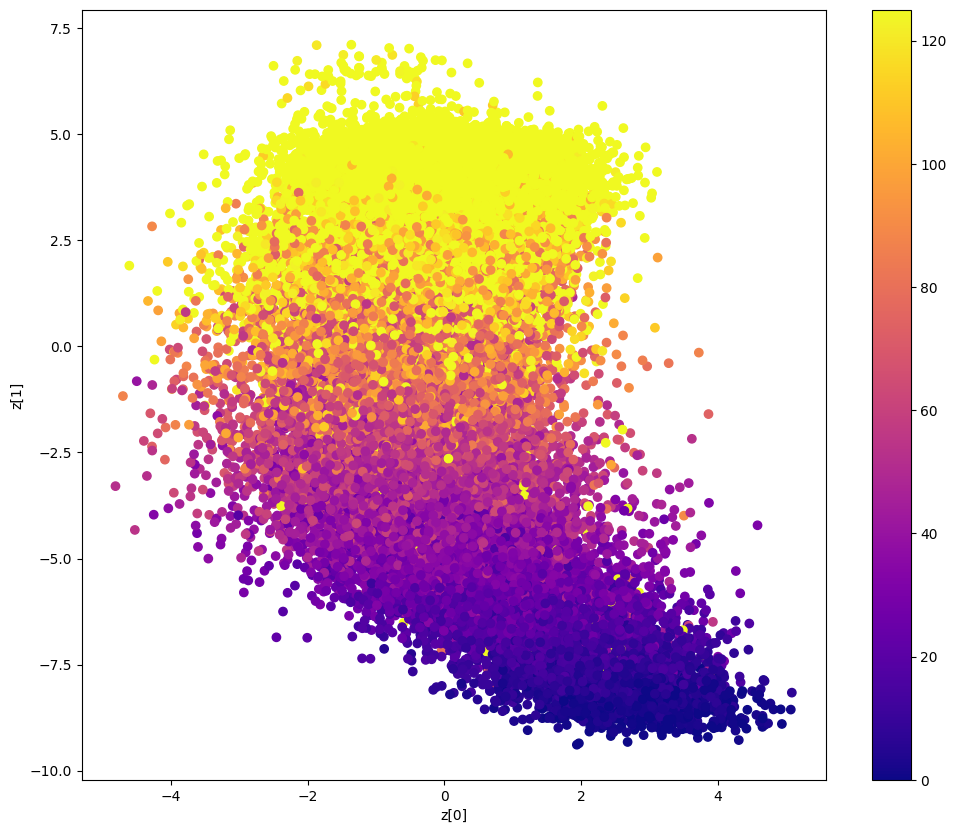

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
plot_latent_space(outputs_train['z'], data["y_train"])

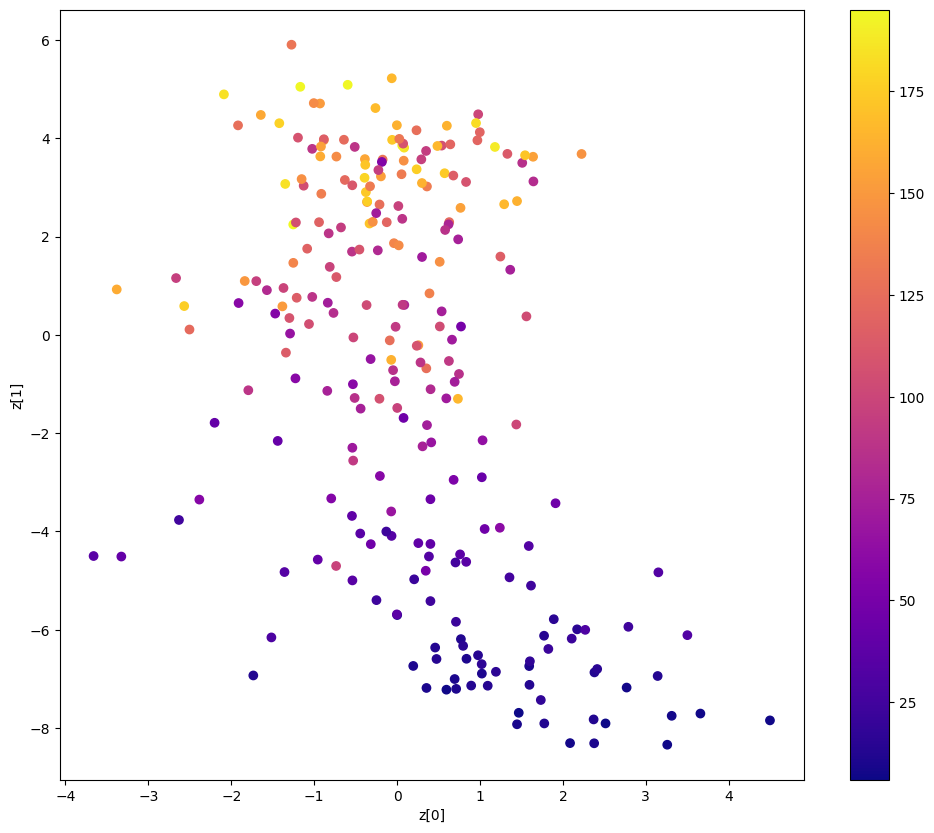

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
plot_latent_space(outputs['z'], data["y_test"])